### Arima

**ARIMA** stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, namely its own lags and the lagged forecast errors, so that equation can be used to forecast future values. An ARIMA model is characterized by 3 terms: `p`, `d`, and `q`:
- **p** is the order of the AR term. It refers to the number of lags to be used as predictors.
- **d** is the order of differencing. It refers to the number of times the data have had past values subtracted.
- **q** is the order of the MA term. It refers to the number of lagged forecast errors in the prediction equation.

### Sarimax

**SARIMAX** stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous variables
- Just like **ARIMA** but could be used with features other than the previous variable

### Target Variable 
- For testing, we want to predict the 7 day volatility

- [1. Importing Packages and Functions](#1)
- [2. Assembling Datasets and Adding Features for Sarimax](#2)
    - [2.1 Adding Features for SARIMAX](#2_1)
        - [2.1.1 RSI](#2_1_1)
        - [2.1.2 Stochastic RSI](#2_1_2)
- [3. Modeling](#3)
    - [3.1 ARIMA](#3_1)
    - [3.1.1 Hyperparameters Tuning for ARIMA](#3_1_1)

## 1. Importing Packages and Functions <a id='1'></a>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima


In [42]:
def calculate_rsi(data, column='price', periods=14):
    """
    Calculate the Relative Strength Index (RSI) of a given DataFrame.
    
    Parameters:
    - data: pandas DataFrame containing the price data.
    - column: string, the name of the column with the price data.
    - periods: int, the number of periods to use for calculating RSI.
    
    Returns:
    - pd.Series: a pandas Series containing the RSI values.
    """
    # Compute price differences (gains/losses)
    delta = data[column].diff()

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # Calculate the average gain and loss
    average_gain = gain.rolling(window=periods, min_periods=periods).mean()
    average_loss = loss.rolling(window=periods, min_periods=periods).mean()

    # Calculate the Relative Strength (RS)
    rs = average_gain / average_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_stoch_rsi(data, column='price', periods=14, stoch_periods=14):
    """
    Calculate the Stochastic Relative Strength Index (StochRSI) of a given DataFrame.
    
    Parameters:
    - data: pandas DataFrame containing the price data.
    - column: string, the name of the column with the price data.
    - periods: int, the number of periods to use for calculating RSI.
    - stoch_periods: int, the number of periods to use for calculating StochRSI.
    
    Returns:
    - pd.Series: a pandas Series containing the StochRSI values.
    """
    # First, calculate RSI
    rsi = calculate_rsi(data, column=column, periods=periods)

    # Calculate StochRSI
    min_rsi = rsi.rolling(window=stoch_periods, min_periods=stoch_periods).min()
    max_rsi = rsi.rolling(window=stoch_periods, min_periods=stoch_periods).max()
    stoch_rsi = (rsi - min_rsi) / (max_rsi - min_rsi)

    return stoch_rsi

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

## 2. Assembling Datasets and Adding Features for Sarimax <a id='2'></a>

In [13]:
data_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_with_volatilities.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['date'], index_col=0)
bitcoin_df ## Enough for ARIMA

,open,high,low,close,Volume BTC,Volume USD,log_return,pct_return,bitcoin_return,MACD,...,ha_open,ha_high,ha_low,150_day_vol,100_day_vol,50_day_vol,30_day_vol,10_day_vol,7_day_vol,5_day_vol
date,,,,,,,,,,,,,,,,,,,,,
2015-10-08,245.00,245.00,243.60,243.95,31.148048,7.611685e+02,-0.004295,-0.004286,0.997147,0.000000,...,NaN,245.000,243.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-09,243.95,249.97,243.60,245.39,56.027841,5.786965e+02,0.005885,0.005903,0.996677,0.114872,...,244.475,249.970,243.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-10,245.39,246.30,244.60,246.30,39.348777,4.024832e+02,0.003702,0.003708,1.001646,0.276155,...,244.670,246.300,244.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-11,246.30,249.50,245.96,249.50,14.487783,1.493239e+02,0.012909,0.012992,1.007784,0.654639,...,245.845,249.500,245.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-12,249.50,249.50,247.60,247.60,62.787480,6.484071e+02,-0.007644,-0.007615,1.012993,0.792146,...,247.900,249.500,247.600,NaN,NaN,NaN,NaN,NaN,NaN,0.008229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-07,22441.68,22549.84,21942.00,22211.93,440.863300,4.085653e+05,-0.010290,-0.010238,90.607263,-105.022044,...,22435.010,22549.840,21942.000,0.026727,0.022474,0.025578,0.027008,0.017580,0.019186,0.017833
2023-03-08,22211.93,22307.23,21583.39,21704.40,397.794102,3.653873e+05,-0.023115,-0.022849,89.417862,-191.122415,...,22326.805,22326.805,21583.390,0.026800,0.022565,0.025800,0.027282,0.016855,0.015354,0.010364
2023-03-09,21704.40,21900.00,19300.00,20289.98,1644.085576,1.422081e+06,-0.067388,-0.065167,86.694768,-369.233162,...,21958.165,21958.165,19300.000,0.027304,0.023550,0.027264,0.029303,0.024494,0.024971,0.027898


### 2.1 Adding Features for SARIMAX <a id='2_1'></a>

#### (check Section 1 for Functions)

#### 2.1.1 RSI <a id='2_1_1'></a>

#### 2.1.2 Stochastic RSI <a id='2_1_2'></a>

## 3. Modeling <a id='3'></a>
- Target variable is 7 day volatility

### 3.1 ARIMA <a id='3_1'></a>

In [15]:
bitcoin_df

,open,high,low,close,Volume BTC,Volume USD,log_return,pct_return,bitcoin_return,MACD,...,ha_open,ha_high,ha_low,150_day_vol,100_day_vol,50_day_vol,30_day_vol,10_day_vol,7_day_vol,5_day_vol
date,,,,,,,,,,,,,,,,,,,,,
2015-10-08,245.00,245.00,243.60,243.95,31.148048,7.611685e+02,-0.004295,-0.004286,0.997147,0.000000,...,NaN,245.000,243.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-09,243.95,249.97,243.60,245.39,56.027841,5.786965e+02,0.005885,0.005903,0.996677,0.114872,...,244.475,249.970,243.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-10,245.39,246.30,244.60,246.30,39.348777,4.024832e+02,0.003702,0.003708,1.001646,0.276155,...,244.670,246.300,244.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-11,246.30,249.50,245.96,249.50,14.487783,1.493239e+02,0.012909,0.012992,1.007784,0.654639,...,245.845,249.500,245.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-12,249.50,249.50,247.60,247.60,62.787480,6.484071e+02,-0.007644,-0.007615,1.012993,0.792146,...,247.900,249.500,247.600,NaN,NaN,NaN,NaN,NaN,NaN,0.008229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-07,22441.68,22549.84,21942.00,22211.93,440.863300,4.085653e+05,-0.010290,-0.010238,90.607263,-105.022044,...,22435.010,22549.840,21942.000,0.026727,0.022474,0.025578,0.027008,0.017580,0.019186,0.017833
2023-03-08,22211.93,22307.23,21583.39,21704.40,397.794102,3.653873e+05,-0.023115,-0.022849,89.417862,-191.122415,...,22326.805,22326.805,21583.390,0.026800,0.022565,0.025800,0.027282,0.016855,0.015354,0.010364
2023-03-09,21704.40,21900.00,19300.00,20289.98,1644.085576,1.422081e+06,-0.067388,-0.065167,86.694768,-369.233162,...,21958.165,21958.165,19300.000,0.027304,0.023550,0.027264,0.029303,0.024494,0.024971,0.027898


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


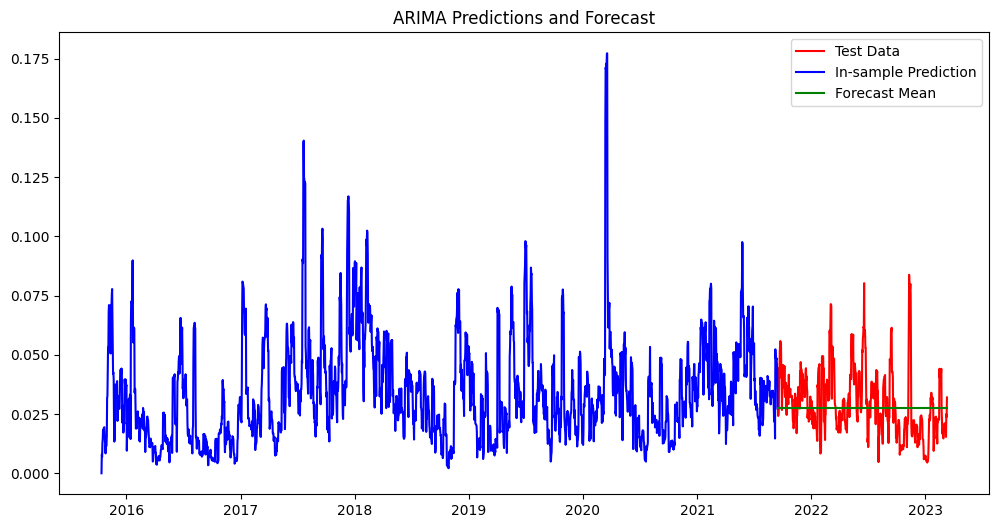

In [31]:
# Setting target to 7_day_vol
data = bitcoin_df['7_day_vol'].dropna()
# Splitting the data into training and testing sets
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train_data = data[:split_index]
test_data = data[split_index:]

model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit()

# Forecast
# In-sample prediction with out-of-sample extension
in_sample_predictions = fitted_model.get_prediction(start=train_data.index[0], end=train_data.index[-1])
out_of_sample_forecast = fitted_model.get_forecast(steps=len(test_data))

# Getting the predicted means
in_sample_mean = in_sample_predictions.predicted_mean
out_of_sample_mean = out_of_sample_forecast.predicted_mean

# Plotting
plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Training Data', color='black')
plt.plot(test_data.index, test_data, label='Test Data', color='red')
plt.plot(train_data.index, in_sample_mean, label='In-sample Prediction', color='blue')
plt.plot(test_data.index, out_of_sample_mean, label='Forecast Mean', color='green')
plt.title('ARIMA Predictions and Forecast')
plt.legend()
plt.show()



# forecast = fitted_model.get_forecast(steps=len(test_data))
# forecast_mean = forecast.predicted_mean
# confidence_intervals = forecast.conf_int()  # Getting the confidence intervals

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Training Data')
# plt.plot(test_data.index, test_data, label='Test Data', color='red')
# plt.plot(test_data.index, forecast_mean, label='Forecast Mean', color='green')

# # Plotting the confidence intervals
# plt.fill_between(test_data.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# plt.title('ARIMA Forecast vs Actuals')
# plt.legend()
# plt.show()

In [39]:
# For dynamic predictions, update the model with each new observation and forecast the next step
dynamic_forecast = []
for t in range(len(test_data)):
    model = ARIMA(train_data+(test_data.iloc[:t]), order=(1, 1, 1))
    fitted_model = model.fit()
    next_step_forecast = fitted_model.forecast()[0]
    dynamic_forecast.append(next_step_forecast)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

In [44]:
def evaluate_arima_model(X, arima_order, split_size=0.8):
	# prepare training dataset
	train_size = int(len(X) * split_size)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [46]:
e, pr = evaluate_arima_model(data, (1,1,1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

NameError: name 'mean_squared_error' is not defined

In [80]:
min_train_size = 30  # Set a minimum training data size
traditional_forecast = np.array([])
dynamic_forecast = np.array([])
current_train_data = train_data.copy().to_numpy()
# current_train_data_dynamic = train_data.copy().to_numpy()
index_to_use = split_index

for t in range(len(test_data)):
    model = ARIMA(current_train_data, order=(1, 1, 1))
    fitted_model_trad = model.fit()

    # For dynamically predicted data
    model = ARIMA(data[:index_to_use], order=(1, 1, 1))
    fitted_model_dynamic = model.fit()

    # Forecast the next time step
    next_step_forecast_trad = fitted_model_trad.forecast()
    next_step_forecast_dyna = fitted_model_dynamic.forecast()
    
    traditional_forecast = np.append(traditional_forecast, next_step_forecast_trad[0])
    dynamic_forecast = np.append(dynamic_forecast, next_step_forecast_dyna[0])
    
    current_train_data = np.append(current_train_data, next_step_forecast_trad[0])
    index_to_use += 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

In [81]:
next_step_forecast_dyna[0]

0.023701139237201737

In [95]:
current_train_data[:-30]

array([0.00795509, 0.00700964, 0.01249779, ..., 0.02767573, 0.02767573,
       0.02767573])

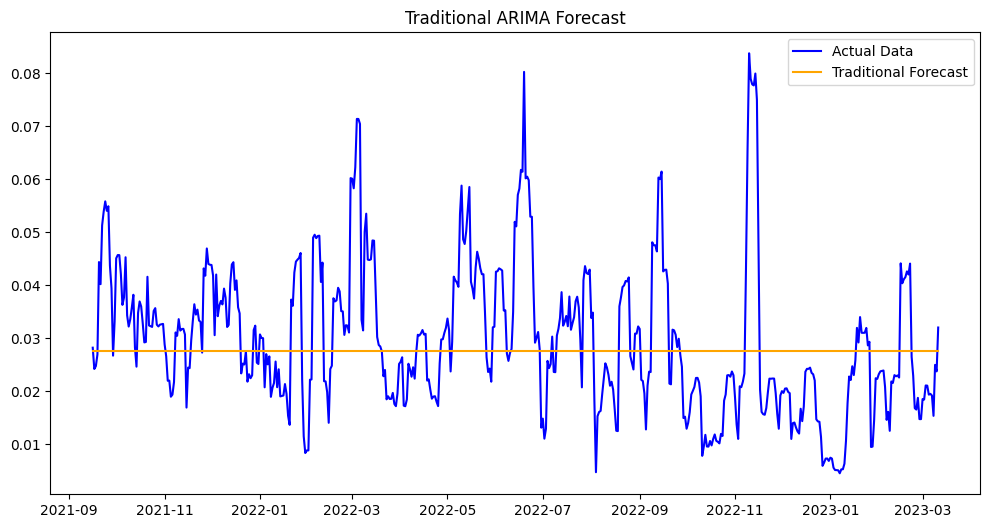

In [96]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue')
plt.plot(test_data.index, traditional_forecast, label='Traditional Forecast', color='orange')
plt.title('Traditional ARIMA Forecast')
plt.legend()
plt.show()

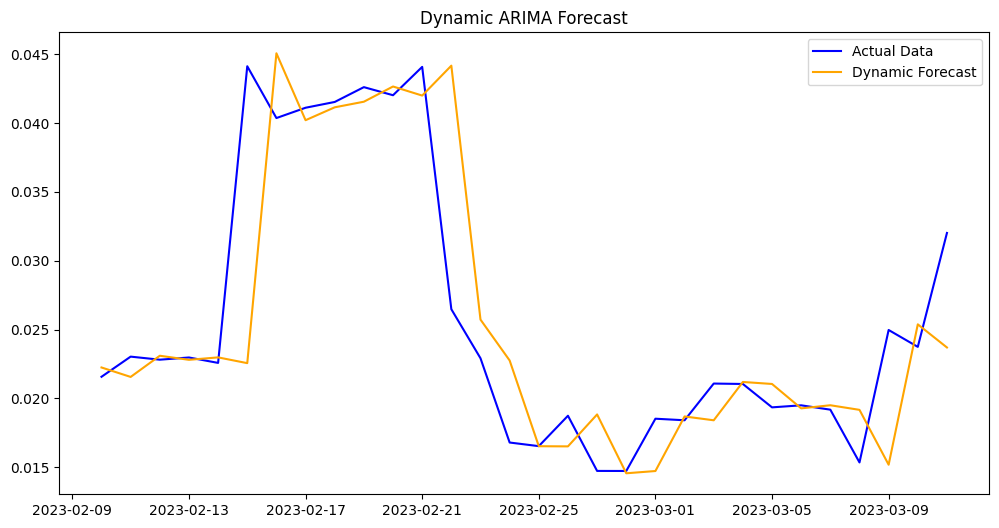

In [98]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[-30:], test_data[-30:], label='Actual Data', color='blue')
plt.plot(test_data.index[-30:], dynamic_forecast[-30:], label='Dynamic Forecast', color='orange')
plt.title('Dynamic ARIMA Forecast')
plt.legend()
plt.show()

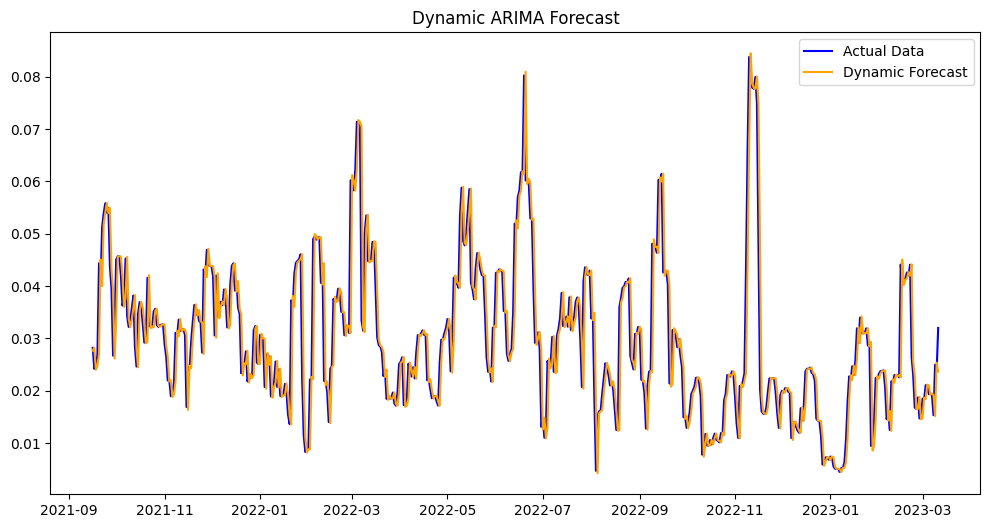

In [61]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue')
plt.plot(test_data.index, dynamic_forecast, label='Dynamic Forecast', color='orange')
plt.title('Dynamic ARIMA Forecast')
plt.legend()
plt.show()

In [50]:
dynamic_forecast_index.shape

(512,)

In [53]:
len(dynamic_forecast)

542

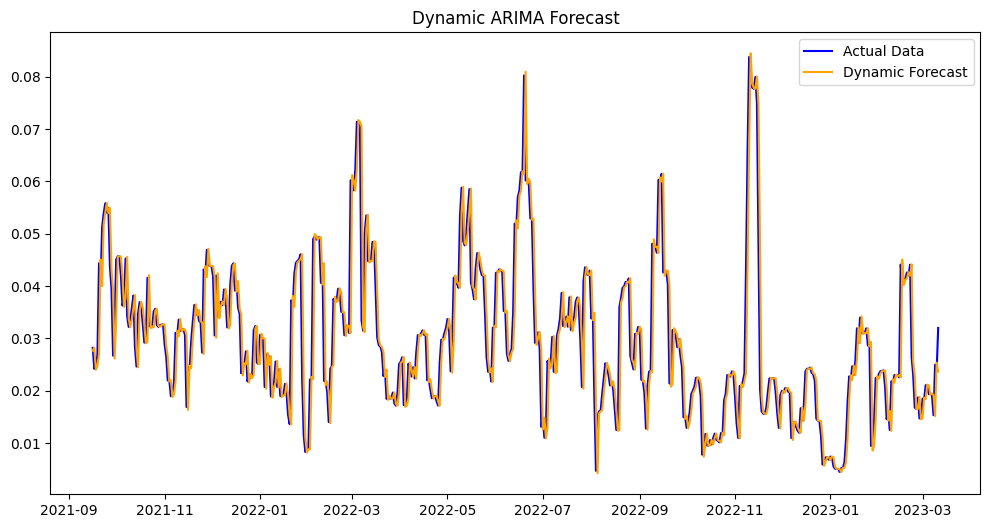

In [55]:
dynamic_forecast_index = data.index[split_index:split_index + min_train_size + len(dynamic_forecast)]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue')
plt.plot(dynamic_forecast_index, dynamic_forecast, label='Dynamic Forecast', color='orange')
plt.title('Dynamic ARIMA Forecast')
plt.legend()
plt.show()

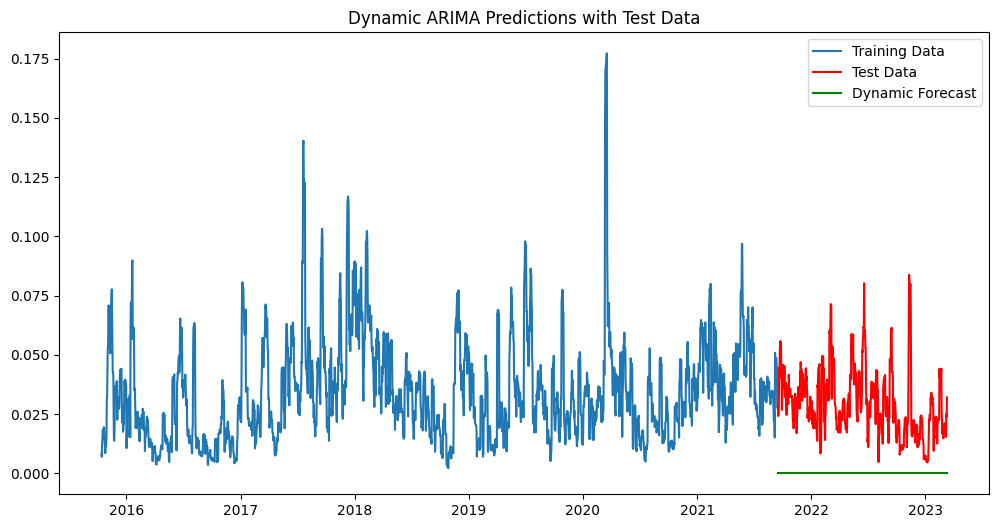

In [40]:
# Plot the dynamic forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='red')
plt.plot(test_data.index, dynamic_forecast, label='Dynamic Forecast', color='green')
plt.title('Dynamic ARIMA Predictions with Test Data')
plt.legend()
plt.show()

#### 3.1.1 Hyperparameters Tuning for ARIMA <a id='3_1_1'></a>